In [1]:
import io
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

2021-10-16 06:35:35.119986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import os  
import cv2
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

# Loading np array from images
def make_dataset(labels, dir_path, IMG_SIZE = 150):
    # initial an empty list X to store image of np.array()
    X = []

    # initial an empty list Z to store labels/names of cat individauls
    Z = []
    
    
    for label in labels:
        DIR = dir_path + label
        for img in tqdm(os.listdir(DIR)):
            path = os.path.join(DIR,img)
            #while n < size:
            # reading images
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # resizing images to (150, 150, 3), 3 is the number of channels - RGB
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

            X.append(np.array(img))
            Z.append(str(label))
            
    ## Transform labels in Z to Y from class number
    le=LabelEncoder()
    Y=le.fit_transform(Z)

    ## Transform and normalize X in the range of [0, 1]
    X=np.array(X, dtype=float)
    X=X/255.
    return X, Y

In [3]:
labels = np.array(['Arani', 'Inti', 'Ocuri', 'Poco', 'Rattaplan', 'Romy'])
np.random.shuffle(labels)

labels_seen = labels[:len(labels)-1]
labels_seen = np.sort(labels_seen)
print('Seen individuals are {}'.format(labels_seen))

labels_unseen = [labels[len(labels)-1]]
labels_unseen = np.sort(labels_unseen)
print('Unseen individuals are {}'.format(labels_unseen))

labels = np.sort(labels)
print('All individuals are {}'.format(labels))

Seen individuals are ['Arani' 'Ocuri' 'Poco' 'Rattaplan' 'Romy']
Unseen individuals are ['Inti']
All individuals are ['Arani' 'Inti' 'Ocuri' 'Poco' 'Rattaplan' 'Romy']


In [4]:
dir_path = '/kaggle/input/auckland-zoo-monkeys/Auckland_Zoo_Monkeys/'

# randomly select seen datset and unseen dataset
# make open set and unseen set 
def make_seen_unseen(labels_seen, labels_unseen):
    
    X_seen, Y_seen = make_dataset(labels_seen, dir_path)
    X_unseen, Y_unseen = make_dataset(labels_unseen, dir_path)
    Y_unseen = ['unseen'] * len(Y_unseen)
    Y_unseen = np.array(Y_unseen)
    return X_seen, Y_seen, X_unseen, Y_unseen

# Configuration Settings

In [5]:
imsize = 150
EPOCHS = 10
batch_size = 64
embeddingDim = 128
num_individuals = len(labels)
num_seen_individuals = len(labels_seen)
num_unseen_individuals = len(labels_unseen)

# Stratified 5 fold Cross Validation

In [6]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)

# Closed Set

In [7]:
X_seen, Y_seen = make_dataset(labels, dir_path)

100%|██████████| 214/214 [00:01<00:00, 126.33it/s]


## Exploring the closed set

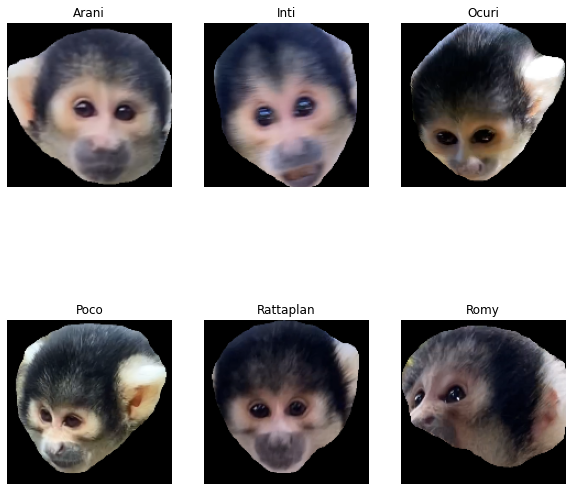

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(X_seen[Y_seen == i][0])
    plt.title(labels[i])
    plt.axis("off")

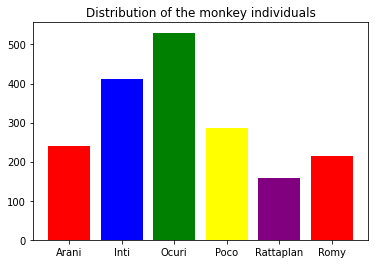

In [9]:
classes, counts = np.unique(Y_seen, return_counts = True)

plt.bar(labels[classes], counts, color=['red', 'blue', 'green', 'yellow', 'purple'])
plt.title('Distribution of the monkey individuals')
plt.show()

## Train/test set split - closed set

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)

# 1. VGG16 Classification Model

In [11]:
def evaluate_vgg16(lr):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_vgg_16 = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(units=num_individuals, activation='softmax')
    ])

    model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

    model_vgg_16.fit(x=x_train, y=y_train,
                     epochs=EPOCHS,
                     batch_size=batch_size,
                     verbose=1)
    
    acc = model_vgg_16.evaluate(x_val, y_val)[1]
    
    return acc

In [12]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

terms = {}
for i in lr:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        terms['{}'.format(i)].append(evaluate_vgg16(lr = i))

2021-10-16 06:36:48.606394: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-16 06:36:48.609773: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-16 06:36:48.649315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-16 06:36:48.650098: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-16 06:36:48.650179: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-16 06:36:48.671407: I tensorflow/stream_executor/platform/def

58892288/58889256 [==============================] - 0s 0us/step


2021-10-16 06:36:51.552162: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-16 06:36:51.564156: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000179999 Hz


Epoch 1/10


2021-10-16 06:36:52.160024: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-10-16 06:36:52.862994: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-10-16 06:36:52.887396: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


19/19 [==============================] - 11s 121ms/step - loss: 1.8418 - acc: 0.2672
Epoch 2/10
19/19 [==============================] - 1s 63ms/step - loss: 1.5682 - acc: 0.4017
Epoch 3/10
19/19 [==============================] - 1s 62ms/step - loss: 1.4467 - acc: 0.4757
Epoch 4/10
19/19 [==============================] - 1s 63ms/step - loss: 1.3389 - acc: 0.5294
Epoch 5/10
19/19 [==============================] - 1s 63ms/step - loss: 1.2549 - acc: 0.5669
Epoch 6/10
19/19 [==============================] - 1s 62ms/step - loss: 1.1770 - acc: 0.5991
Epoch 7/10
19/19 [==============================] - 1s 66ms/step - loss: 1.1025 - acc: 0.6725
Epoch 8/10
19/19 [==============================] - 1s 64ms/step - loss: 1.0539 - acc: 0.6654
Epoch 9/10
19/19 [==============================] - 1s 63ms/step - loss: 1.0111 - acc: 0.6831
Epoch 10/10
10/10 [==============================] - 2s 76ms/step - loss: 1.0349 - acc: 0.6395
Epoch 1/10
19/19 [==============================] - 2s 62ms/step - l

## Statistical tests - VGG16 

In [13]:
import pandas as pd
acc_vgg16 = pd.DataFrame(terms)
table_vgg16 = acc_vgg16.agg(['mean', 'std']).T
table_vgg16

,mean,std
1e-05,0.665090,0.023922
0.0001,0.876780,0.016625
0.001,0.897207,0.019164
0.01,0.885640,0.016032
0.1,0.289313,0.002445


In [14]:
! pip install autorank
from autorank import autorank, plot_stats, create_report

In [15]:
results = autorank(acc_vgg16, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
        meanrank      mean       std  ci_lower  ci_upper effect_size  \
0.001        1.0  0.897207  0.019164  0.857748  0.936666         0.0   
0.01         2.2  0.885640  0.016032  0.852631  0.918649    0.654707   
0.0001       2.8  0.876780  0.016625  0.842549  0.911011    1.138649   
1e-05        4.0  0.665090  0.023922  0.615835  0.714346   10.709525   
0.1          5.0  0.289313  0.002445  0.284278  0.294348   44.498863   

         magnitude  
0.001   negligible  
0.01        medium  
0.0001       large  
1e-05        large  
0.1          large  
pvalue=0.0006677296603150804
cd=2.7277508838690387
omnibus=friedman
posthoc=nemenyi
all_normal=True
pvals_shapiro=[0.4485947787761688, 0.20684844255447388, 0.5345825552940369, 0.9414794445037842, 0.7167077660560608]
homoscedastic=False
pval_homogeneity=0.01925313319238278
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.01
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_

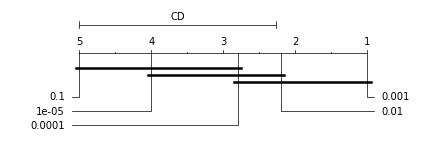

In [16]:
plot_stats(results)
plt.show()

In [17]:
create_report(results)

The statistical analysis was conducted for 5 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.207). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.019) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference 

In [18]:
acc_best_vgg16 =  acc_vgg16['0.001']
acc_best_vgg16

0    0.884354
1    0.874150
2    0.918367
3    0.914966
4    0.894198
Name: 0.001, dtype: float64

## Retrain VGG16 classification model on closed set

In [19]:
# choose best lr
lr = 0.001

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                      input_shape = (imsize,imsize,3),
                      weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_vgg_16 = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=num_individuals, activation='softmax')
])

model_vgg_16.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='sparse_categorical_crossentropy', metrics=['acc']) 

model_vgg_16.fit(x=X_train, y=Y_train,
                 epochs=EPOCHS,
                 batch_size=batch_size,
                 verbose=1)

Epoch 1/10
23/23 [==============================] - 5s 180ms/step - loss: 5.1534 - acc: 0.2868
Epoch 2/10
23/23 [==============================] - 1s 65ms/step - loss: 0.9468 - acc: 0.6571
Epoch 3/10
23/23 [==============================] - 1s 65ms/step - loss: 0.5195 - acc: 0.8591
Epoch 4/10
23/23 [==============================] - 1s 65ms/step - loss: 0.3874 - acc: 0.9026
Epoch 5/10
23/23 [==============================] - 1s 65ms/step - loss: 0.2660 - acc: 0.9596
Epoch 6/10
23/23 [==============================] - 1s 64ms/step - loss: 0.1934 - acc: 0.9752
Epoch 7/10
23/23 [==============================] - 1s 64ms/step - loss: 0.1498 - acc: 0.9835
Epoch 8/10
23/23 [==============================] - 1s 64ms/step - loss: 0.1057 - acc: 0.9929
Epoch 9/10
23/23 [==============================] - 1s 64ms/step - loss: 0.0747 - acc: 0.9982
Epoch 10/10
23/23 [==============================] - 1s 64ms/step - loss: 0.0623 - acc: 0.9974


In [20]:
acc_test_vgg16 = round(model_vgg_16.evaluate(X_test, Y_test)[1], 2)

print('Accuracy of VGG16 on the test set is {}'.format(acc_test_vgg16))

12/12 [==============================] - 1s 101ms/step - loss: 0.3111 - acc: 0.8913
Accuracy of VGG16 on the test set is 0.89


## Misclassified Monkeys - VGG16 - Closed set

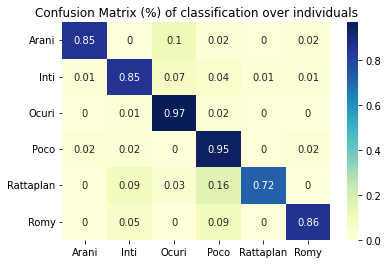

In [21]:
pred = np.argmax(model_vgg_16.predict(X_test), axis = 1)

_, counts = np.unique(Y_test, return_counts=True)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

matrix = np.round(confusion_matrix(Y_test, pred) / counts[:, None], 2)
matrix = pd.DataFrame(matrix, index=labels, columns=labels)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classification over individuals')
plt.show()

# 2. Contrastive Loss

In [22]:
# Helper Function 

# Create positive pairs and negative pairs
import random
def create_pairs(images, labels, num_individuals):
    # initialize two empty lists to hold the (image, image) pairs and
    # labels to indicate if a pair is positive (0) or negative (1)
    np.random.seed(2021)
    pairImages = []
    pairLabels = []
    
    # calculate the total number of classes present in the dataset
    # and then build a list of indexes for each class label that
    # provides the indexes for all examples with a given label
    idx = [np.where(labels == i)[0] for i in range(num_individuals)]
    
    # loop voer all images
    for idxA in range(len(images)):
        # grab the current image and label belonging to the current iteration
        currentImage = images[idxA]
        label = labels[idxA]
        
        # randomly pick on an image that belongs to the *same* class label
        posId = random.choice(idx[label])
        posImage = images[posId]
        
        # prepare a positive pair and update the images and labels
        pairImages.append([currentImage, posImage])
        pairLabels.append([0])
        
        # grab the indices for each of the class labels *not* equal to
        # the current label and randomly pick an image corresponding
        # to a label *not* equal to the current label
        negId = np.where(labels != label)[0]
        negIdx = random.choice(negId)
        negImage = images[negIdx]
        
        # prepare a negative pair of images and update out lists
        pairImages.append([currentImage, negImage])
        pairLabels.append([1])
    
    return (np.array(pairImages), np.array(pairLabels))



# Function to calculate the distance between two images (Euclidean Distance used here)
import tensorflow.keras.backend as K
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
                       keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


# contrastive loss function
def contrastive_loss(y, preds, margin=1):
    # explicitly cast the true class label data type to the predicted
    # class label data type (otherwise we run the risk of having two
    # separate data types, causing TensorFlow to error out)
    y = tf.cast(y, preds.dtype)
    # calculate the contrastive loss between the true labels and
    # the predicted labels
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean((1 - y) * squaredPreds + y * squaredMargin)
    # return the computed contrastive loss to the calling function
    return loss

In [23]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    x_test_embedding = model_cl.predict(x_val)
    acc = round(knn_cl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the val set with contrastive loss is {}'.format(acc))
    
    return acc

In [24]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [1, 3, 5]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train, num_individuals)
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_cl_closed_set(lr = i, k = j))

2021-10-16 06:45:01.439630: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634500000 exceeds 10% of free system memory.
2021-10-16 06:45:02.767184: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634500000 exceeds 10% of free system memory.


Epoch 1/10
37/37 [==============================] - 10s 236ms/step - loss: 0.2470
Epoch 2/10
37/37 [==============================] - 5s 126ms/step - loss: 0.2353
Epoch 3/10
37/37 [==============================] - 5s 126ms/step - loss: 0.2231
Epoch 4/10
37/37 [==============================] - 5s 124ms/step - loss: 0.2159
Epoch 5/10
37/37 [==============================] - 5s 125ms/step - loss: 0.2049
Epoch 6/10
37/37 [==============================] - 5s 127ms/step - loss: 0.1967
Epoch 7/10
37/37 [==============================] - 5s 125ms/step - loss: 0.1885
Epoch 8/10
37/37 [==============================] - 5s 124ms/step - loss: 0.1747
Epoch 9/10
37/37 [==============================] - 5s 126ms/step - loss: 0.1731
Epoch 10/10
37/37 [==============================] - 5s 126ms/step - loss: 0.1620
Accuracy on the val set with contrastive loss is 0.82


2021-10-16 06:46:37.016874: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634500000 exceeds 10% of free system memory.
2021-10-16 06:46:37.745202: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634500000 exceeds 10% of free system memory.


Epoch 1/10
37/37 [==============================] - 6s 127ms/step - loss: 0.2465
Epoch 2/10
37/37 [==============================] - 5s 126ms/step - loss: 0.2327
Epoch 3/10
37/37 [==============================] - 5s 126ms/step - loss: 0.2256
Epoch 4/10
37/37 [==============================] - 5s 125ms/step - loss: 0.2163
Epoch 5/10
37/37 [==============================] - 5s 127ms/step - loss: 0.2054
Epoch 6/10
37/37 [==============================] - 5s 126ms/step - loss: 0.1949
Epoch 7/10
37/37 [==============================] - 5s 125ms/step - loss: 0.1867
Epoch 8/10
37/37 [==============================] - 5s 127ms/step - loss: 0.1794
Epoch 9/10
37/37 [==============================] - 5s 124ms/step - loss: 0.1731
Epoch 10/10
37/37 [==============================] - 5s 125ms/step - loss: 0.1647
Accuracy on the val set with contrastive loss is 0.77


2021-10-16 06:48:07.254813: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 634500000 exceeds 10% of free system memory.


Epoch 1/10
37/37 [==============================] - 6s 124ms/step - loss: 0.2453
Epoch 2/10
37/37 [==============================] - 5s 124ms/step - loss: 0.2358
Epoch 3/10
37/37 [==============================] - 5s 125ms/step - loss: 0.2254
Epoch 4/10
37/37 [==============================] - 5s 124ms/step - loss: 0.2173
Epoch 5/10
37/37 [==============================] - 5s 125ms/step - loss: 0.2067
Epoch 6/10
37/37 [==============================] - 5s 124ms/step - loss: 0.1956
Epoch 7/10
37/37 [==============================] - 5s 126ms/step - loss: 0.1876
Epoch 8/10
37/37 [==============================] - 5s 124ms/step - loss: 0.1793
Epoch 9/10
37/37 [==============================] - 5s 125ms/step - loss: 0.1716
Epoch 10/10
37/37 [==============================] - 5s 125ms/step - loss: 0.1649
Accuracy on the val set with contrastive loss is 0.77
Epoch 1/10
37/37 [==============================] - 5s 124ms/step - loss: 0.2415
Epoch 2/10
37/37 [==============================] - 5s

## Statistical tests - Contrastive Loss - closed set

In [25]:
import pandas as pd
acc_cl_closed_set = pd.DataFrame(terms)
table_cl_closed_set = acc_cl_closed_set.agg(['mean', 'std']).T
table_cl_closed_set

,mean,std
1e-05_1,0.838,0.020494
1e-05_3,0.802,0.025884
1e-05_5,0.796,0.016733
0.0001_1,0.882,0.026833
0.0001_3,0.864,0.021909
0.0001_5,0.870,0.018708
0.001_1,0.854,0.020736
0.001_3,0.858,0.020494
0.001_5,0.860,0.020000
0.01_1,0.780,0.045277


In [26]:
results = autorank(acc_cl_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
          meanrank   mean       std  ci_lower  ci_upper effect_size  \
0.0001_1       2.1  0.882  0.026833  0.850345  0.913655         0.0   
0.0001_5       2.6  0.870  0.018708  0.838345  0.901655    0.518805   
0.0001_3       3.7  0.864  0.021909  0.832345  0.895655    0.734847   
0.001_5        4.3  0.860  0.020000  0.828345  0.891655     0.92967   
0.001_3        4.4  0.858  0.020494  0.826345  0.889655    1.005249   
0.001_1        4.7  0.854  0.020736  0.822345  0.885655    1.167681   
1e-05_1        6.3  0.838  0.020494  0.806345  0.869655    1.842957   
1e-05_3        9.3  0.802  0.025884  0.770345  0.833655    3.034573   
1e-05_5        9.6  0.796  0.016733  0.764345  0.827655    3.846037   
0.01_3         9.8  0.796  0.024083  0.764345  0.827655    3.373198   
0.01_1        11.0  0.780  0.045277  0.748345  0.811655    2.740787   
0.01_5        11.5  0.776  0.027019  0.744345  0.807655    3.936741   
0.1_5         12.8  0.730  0.043589  0.698345  0.761655   

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


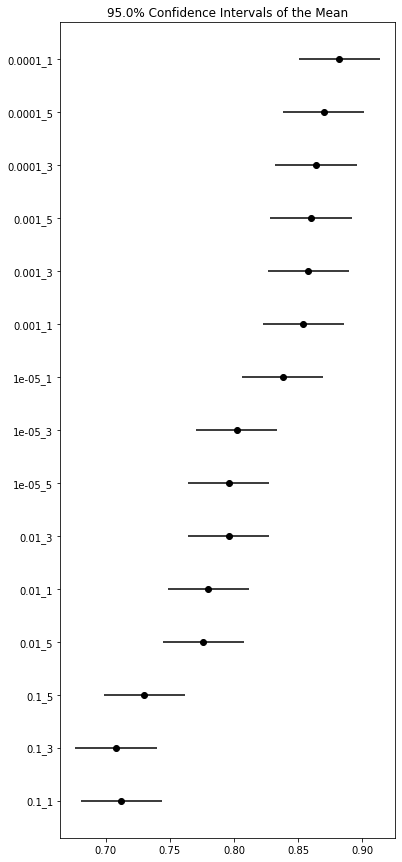

In [27]:
plot_stats(results)
plt.show()

In [28]:
create_report(results)

The statistical analysis was conducted for 15 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.046). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.696) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

In [29]:
acc_best_cl_closed_set =  acc_cl_closed_set['0.0001_1']
acc_best_cl_closed_set

0    0.87
1    0.84
2    0.90
3    0.90
4    0.90
Name: 0.0001_1, dtype: float64

## Retrain Contrastive Loss on closed set

Epoch 1/10
46/46 [==============================] - 11s 233ms/step - loss: 0.2410
Epoch 2/10
46/46 [==============================] - 6s 124ms/step - loss: 0.1767
Epoch 3/10
46/46 [==============================] - 6s 125ms/step - loss: 0.1401
Epoch 4/10
46/46 [==============================] - 6s 125ms/step - loss: 0.1208
Epoch 5/10
46/46 [==============================] - 6s 125ms/step - loss: 0.0985
Epoch 6/10
46/46 [==============================] - 6s 124ms/step - loss: 0.0841
Epoch 7/10
46/46 [==============================] - 6s 124ms/step - loss: 0.0740
Epoch 8/10
46/46 [==============================] - 6s 126ms/step - loss: 0.0624
Epoch 9/10
46/46 [==============================] - 6s 125ms/step - loss: 0.0571
Epoch 10/10
46/46 [==============================] - 6s 125ms/step - loss: 0.0509


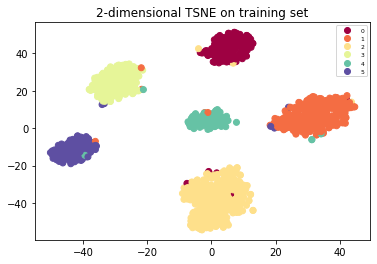

Accuracy of Constractive Loss on test set is 0.92


In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import pylab as plot
params = {'legend.fontsize': 6,
          'legend.handlelength': 3}
plot.rcParams.update(params)


# choose best lr and k
lr = 0.0001
k = 1

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

    
imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
featsA = model_cl(imgA)
featsB = model_cl(imgB)
   
distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train, num_individuals)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
          batch_size = batch_size,
          epochs=EPOCHS, 
          verbose=1)
    
embedding_train_cl = []
for i in range(len(Y_train)):
        embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
embedding_train_cl = np.array(embedding_train_cl, dtype=float)

tsne_cl = TSNE(n_components=2, random_state=1).fit_transform(embedding_train_cl)

scatter = plt.scatter(tsne_cl[:, 0], tsne_cl[:, 1], c=Y_train, cmap=plt.cm.Spectral)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, range(len(labels)))
plt.title('2-dimensional TSNE on training set')
plt.show()

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
x_test_embedding = model_cl.predict(X_test)
acc_cl_test_closed_set = round(knn_cl.score(x_test_embedding, Y_test), 2)
pred = knn_cl.predict(x_test_embedding)

print('Accuracy of Constractive Loss on test set is {}'.format(round(acc_cl_test_closed_set, 2)))

## Misclassified Monkeys - Closed set (Contrastive Loss)

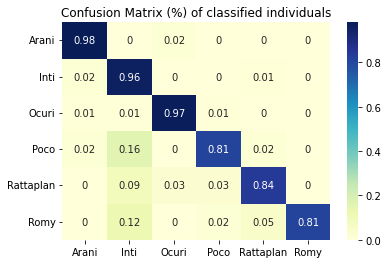

In [31]:
_, counts = np.unique(Y_test, return_counts=True)

matrix = np.round(confusion_matrix(Y_test, pred) / counts[:, None], 2)
matrix = pd.DataFrame(matrix, index=labels, columns=labels)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classified individuals')
plt.show()

# 3. Triplet Loss

In [32]:
def evaluate_tl_closed_set(lr, k):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    x_test_embedding = model_tl.predict(x_val)
    acc = round(knn_tl.score(x_test_embedding, y_val), 2)
    print('Accuracy on the the val set with Tripolet Loss is {}'.format(acc))
    
    return acc

In [33]:
lr = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
k = [1, 3, 5]

terms = {}
for i in lr:
    for j in k:
        terms['{}_{}'.format(i, j)] = []
        
for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in lr:
        for j in k:
            terms['{}_{}'.format(i, j)].append(evaluate_tl_closed_set(lr = i, k = j))

Epoch 1/10
19/19 [==============================] - 3s 64ms/step - loss: 0.9932
Epoch 2/10
19/19 [==============================] - 1s 62ms/step - loss: 0.9915
Epoch 3/10
19/19 [==============================] - 1s 63ms/step - loss: 0.9887
Epoch 4/10
19/19 [==============================] - 1s 63ms/step - loss: 0.9819
Epoch 5/10
19/19 [==============================] - 1s 63ms/step - loss: 0.9747
Epoch 6/10
19/19 [==============================] - 1s 63ms/step - loss: 0.9601
Epoch 7/10
19/19 [==============================] - 1s 63ms/step - loss: 0.9482
Epoch 8/10
19/19 [==============================] - 1s 63ms/step - loss: 0.9346
Epoch 9/10
19/19 [==============================] - 1s 64ms/step - loss: 0.9246
Epoch 10/10
19/19 [==============================] - 1s 62ms/step - loss: 0.9004
Accuracy on the the val set with Tripolet Loss is 0.85
Epoch 1/10
19/19 [==============================] - 2s 64ms/step - loss: 0.9932
Epoch 2/10
19/19 [==============================] - 1s 63ms/step

## Statistical tests - Triplet loss - Closed Set

In [34]:
import pandas as pd
acc_tl_closed_set = pd.DataFrame(terms)
table_tl_closed_set = acc_tl_closed_set.agg(['mean', 'std']).T
table_tl_closed_set

,mean,std
1e-05_1,0.860,0.020000
1e-05_3,0.852,0.014832
1e-05_5,0.818,0.038341
0.0001_1,0.892,0.022804
0.0001_3,0.888,0.023875
0.0001_5,0.888,0.021679
0.001_1,0.896,0.023022
0.001_3,0.892,0.014832
0.001_5,0.902,0.021679
0.01_1,0.740,0.024495


In [35]:
results = autorank(acc_tl_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
          meanrank   mean       std  ci_lower  ci_upper effect_size  \
0.001_5        2.3  0.902  0.021679  0.865868  0.938132         0.0   
0.001_1        2.9  0.896  0.023022  0.859868  0.932132    0.268328   
0.0001_1       3.7  0.892  0.022804  0.855868  0.928132    0.449467   
0.001_3        3.7  0.892  0.014832  0.855868  0.928132    0.538382   
0.0001_3       4.2  0.888  0.023875  0.851868  0.924132    0.613941   
0.0001_5       4.3  0.888  0.021679  0.851868  0.924132    0.645772   
1e-05_1        7.3  0.860  0.020000  0.823868  0.896132    2.013746   
1e-05_3        7.7  0.852  0.014832  0.815868  0.888132     2.69191   
1e-05_5        9.1  0.818  0.038341  0.781868  0.854132    2.697077   
0.01_3        11.1  0.750  0.045826  0.713868  0.786132    4.240255   
0.01_5        11.1  0.762  0.058052  0.725868  0.798132    3.195048   
0.01_1        11.9  0.740  0.024495  0.703868  0.776132    7.003871   
0.1_5         12.9  0.702  0.056745  0.665868  0.738132   

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


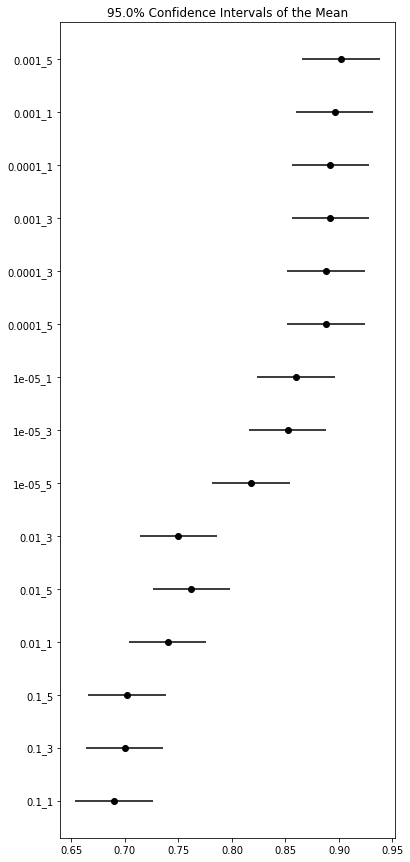

In [36]:
plot_stats(results)
plt.show()

In [37]:
create_report(results)

The statistical analysis was conducted for 15 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.257). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.089) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confid

In [38]:
acc_best_tl_closed_set =  acc_tl_closed_set['0.001_5']
acc_best_tl_closed_set

0    0.90
1    0.87
2    0.93
3    0.91
4    0.90
Name: 0.001_5, dtype: float64

## Retrain Triplet Loss on closed set

Epoch 1/10
23/23 [==============================] - 2s 67ms/step - loss: 0.9730
Epoch 2/10
23/23 [==============================] - 1s 65ms/step - loss: 0.9138
Epoch 3/10
23/23 [==============================] - 1s 65ms/step - loss: 0.7984
Epoch 4/10
23/23 [==============================] - 1s 65ms/step - loss: 0.7343
Epoch 5/10
23/23 [==============================] - 1s 64ms/step - loss: 0.6209
Epoch 6/10
23/23 [==============================] - 1s 65ms/step - loss: 0.6123
Epoch 7/10
23/23 [==============================] - 1s 64ms/step - loss: 0.5449
Epoch 8/10
23/23 [==============================] - 1s 65ms/step - loss: 0.5581
Epoch 9/10
23/23 [==============================] - 2s 65ms/step - loss: 0.5241
Epoch 10/10
23/23 [==============================] - 1s 64ms/step - loss: 0.4513


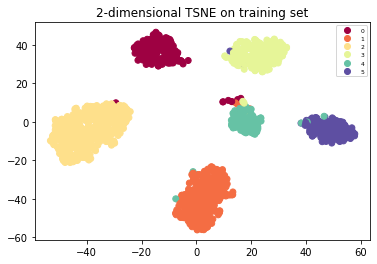

Accuracy of Triplet Loss on the test set is 0.91


In [39]:
# choose best lr and k
lr = 0.001
k = 5

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
        layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x=X_train, y= Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

tsne_tl = TSNE(n_components=2, random_state=1).fit_transform(embedding_train_tl)

scatter = plt.scatter(tsne_tl[:, 0], tsne_tl[:, 1], c=Y_train, cmap=plt.cm.Spectral)
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, range(len(labels)))
plt.title('2-dimensional TSNE on training set')
plt.show()

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
x_test_embedding = model_tl.predict(X_test)
acc_tl_test_closed_set = round(knn_tl.score(x_test_embedding, Y_test), 2)
pred = knn_tl.predict(x_test_embedding)

print('Accuracy of Triplet Loss on the test set is {}'.format(round(acc_tl_test_closed_set, 2)))

## Misclassified Monkeys - Closed set (Triplet Loss)

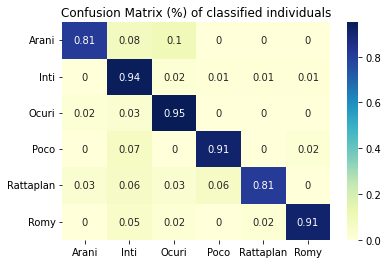

In [40]:
_, counts = np.unique(Y_test, return_counts=True)

matrix = np.round(confusion_matrix(Y_test, pred) / counts[:, None], 2)
matrix = pd.DataFrame(matrix, index=labels, columns=labels)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classified individuals')
plt.show()

# Open Set

In [41]:
X_seen, Y_seen, X_unseen, Y_unseen = make_seen_unseen(labels_seen, labels_unseen)

100%|██████████| 411/411 [00:03<00:00, 108.01it/s]


## Train/test set split - open set

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_seen, Y_seen, test_size = 0.2, stratify = Y_seen, random_state=2021)

X_val_unseen, X_test_unseen, Y_val_unseen, Y_test_unseen = train_test_split(X_unseen, Y_unseen, test_size = 0.5, random_state=2021)

# 1. Contrastive Loss

In [43]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_cl_open_set(lr=0.0001, k = 1, d_t = 0.5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize,imsize,3),
                                                      weights = 'imagenet')
    
    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_cl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    
    imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
    
    featsA = model_cl(imgA)
    featsB = model_cl(imgB)
   
    distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])
    model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)
    model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

    model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
              batch_size = batch_size,
              epochs=EPOCHS, 
              verbose=1)
    
    embedding_train_cl = []
    for i in range(len(y_train)):
        embedding_train_cl.append(model_cl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
    embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

    knn_cl = KNeighborsClassifier(n_neighbors = k)
    knn_cl.fit(embedding_train_cl, y_train)
    
    #find the center point for each class in training set
    support_cl = []
    for i in np.unique(y_train):
        support_cl.append(np.mean(embedding_train_cl[y_train==i], axis=0))
        
    support_cl = np.array(support_cl, dtype=float)
    
    pred = []
    temp_x = np.append(x_val, X_val_unseen, axis=0)
    temp_y = np.append(y_val, Y_val_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_cl.predict(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_cl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_cl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the val set with Contrastive Loss is {}'.format(acc_open))
    
    return acc_open

In [44]:
d_t = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

terms = {}
for i in d_t:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    (pairTrain, labelTrain) = create_pairs(x_train, y_train, num_seen_individuals)
    
    for i in d_t:
        terms['{}'.format(i)].append(evaluate_cl_open_set(d_t = i))

Epoch 1/10
29/29 [==============================] - 4s 122ms/step - loss: 0.2473
Epoch 2/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1749
Epoch 3/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1422
Epoch 4/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1127
Epoch 5/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0956
Epoch 6/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0770
Epoch 7/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0630
Epoch 8/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0574
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0470
Epoch 10/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0392
The accuracy on the val set with Contrastive Loss is 0.6
Epoch 1/10
29/29 [==============================] - 4s 123ms/step - loss: 0.2451
Epoch 2/10
29/29 [==============================] -

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 0.2376
Epoch 2/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1710
Epoch 3/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1277
Epoch 4/10
29/29 [==============================] - 4s 122ms/step - loss: 0.1047
Epoch 5/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0849
Epoch 6/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0732
Epoch 7/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0602
Epoch 8/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0501
Epoch 9/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0445
Epoch 10/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0354
The accuracy on the val set with Contrastive Loss is 0.6
Epoch 1/10
29/29 [==============================] - 5s 123ms/step - loss: 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 4s 123ms/step - loss: 0.2431
Epoch 2/10
29/29 [==============================] - 4s 128ms/step - loss: 0.1729
Epoch 3/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1311
Epoch 4/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1079
Epoch 5/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0927
Epoch 6/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0733
Epoch 7/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0623
Epoch 8/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0518
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0445
Epoch 10/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0355
The accuracy on the val set with Contrastive Loss is 0.59
Epoch 1/10
29/29 [==============================] - 4s 125ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 4s 122ms/step - loss: 0.2430
Epoch 2/10
29/29 [==============================] - 4s 122ms/step - loss: 0.1736
Epoch 3/10
29/29 [==============================] - 4s 122ms/step - loss: 0.1335
Epoch 4/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1081
Epoch 5/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0880
Epoch 6/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0747
Epoch 7/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0623
Epoch 8/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0539
Epoch 9/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0449
Epoch 10/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0386


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 5s 126ms/step - loss: 0.2389
Epoch 2/10
29/29 [==============================] - 4s 122ms/step - loss: 0.1703
Epoch 3/10
29/29 [==============================] - 4s 122ms/step - loss: 0.1199
Epoch 4/10
29/29 [==============================] - 4s 124ms/step - loss: 0.1080
Epoch 5/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0864
Epoch 6/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0740
Epoch 7/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0621
Epoch 8/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0517
Epoch 9/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0432
Epoch 10/10
29/29 [==============================] - 4s 125ms/step - loss: 0.0385
The accuracy on the val set with Contrastive Loss is 0.61
Epoch 1/10
29/29 [==============================] - 5s 122ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


The accuracy on the val set with Contrastive Loss is 0.0
Epoch 1/10
29/29 [==============================] - 4s 123ms/step - loss: 0.2498
Epoch 2/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1791
Epoch 3/10
29/29 [==============================] - 4s 122ms/step - loss: 0.1324
Epoch 4/10
29/29 [==============================] - 4s 123ms/step - loss: 0.1064
Epoch 5/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0959
Epoch 6/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0762
Epoch 7/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0649
Epoch 8/10
29/29 [==============================] - 4s 124ms/step - loss: 0.0567
Epoch 9/10
29/29 [==============================] - 4s 123ms/step - loss: 0.0462
Epoch 10/10
29/29 [==============================] - 4s 122ms/step - loss: 0.0394
The accuracy on the val set with Contrastive Loss is 0.64
Epoch 1/10
29/29 [==============================] - 5s 125ms/step - loss: 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:75: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


## Statistical tests - Contrastive Loss - Open set

In [45]:
import pandas as pd
acc_cl_open_set = pd.DataFrame(terms)
table_cl_open_set = acc_cl_open_set.agg(['mean', 'std']).T
table_cl_open_set

,mean,std
0.2,0.608,0.019235
0.3,0.736,0.008944
0.4,0.686,0.028810
0.5,0.542,0.034205
0.6,0.504,0.008944
0.7,0.384,0.214779
0.8,0.000,0.000000


In [46]:
results = autorank(acc_cl_open_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
     meanrank  median       mad ci_lower ci_upper effect_size magnitude
0.3       1.1    0.73       0.0     0.73     0.75         NaN     large
0.4       1.9    0.67  0.014826     0.66     0.73    5.723244     large
0.2       3.0    0.60  0.014826     0.59     0.64   12.400362     large
0.5       4.2    0.55  0.044478      0.5     0.59    5.723244     large
0.6       4.8    0.50       0.0      0.5     0.52         inf     large
0.7       6.1    0.48  0.014826      0.0     0.49   23.846849     large
0.8       6.9    0.00       0.0      0.0      0.0         inf     large
pvalue=4.4906191613789444e-05
cd=4.028125147160942
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.22297842800617218, 0.04595435410737991, 0.2692832946777344, 0.8139509558677673, 0.00013097839837428182, 0.00037141464417800307, 1.0]
homoscedastic=True
pval_homogeneity=0.5069935716037887
homogeneity_test=levene
alpha=0.05
alpha_normality=0.0071428571428571435
num_samples=5
posterior_ma

/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/opt/conda/lib/python3.7/site-packages/autorank/_util.py:107: RuntimeWarning: invalid value encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)
/opt/conda/lib/python3.7/site-packages/autorank/_util.py:107: RuntimeWarning: divide by zero encountered in double_scalars
  return (np.median(x) - np.median(y)) / _pooled_mad(x, y)


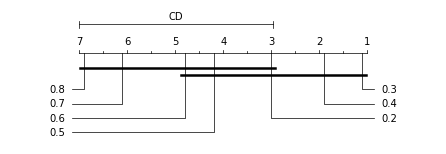

In [47]:
plot_stats(results)
plt.show()

In [48]:
create_report(results)

The statistical analysis was conducted for 7 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations 0.6 (p=0.000) and 0.7 (p=0.000). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=4.028 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of the Friedman test that there is no

In [49]:
acc_best_cl_open_set =  acc_cl_open_set['0.3']
acc_best_cl_open_set

0    0.73
1    0.74
2    0.75
3    0.73
4    0.73
Name: 0.3, dtype: float64

## Retrain Contrastive Loss on Open set

In [50]:
from sklearn.neighbors import KNeighborsClassifier

# choose the best value of d_t
lr = 0.0001
k = 1
d_t = 0.3

base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize,imsize,3),
                                                  weights = 'imagenet')
    
# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_cl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

imgA = tf.keras.layers.Input(shape=((imsize, imsize, 3)))
imgB = tf.keras.layers.Input(shape=((imsize, imsize, 3)))

featsA = model_cl(imgA)
featsB = model_cl(imgB)

distance = tf.keras.layers.Lambda(euclidean_distance)([featsA, featsB])

model = tf.keras.Model(inputs=[imgA, imgB], outputs=distance)

model.compile(loss=contrastive_loss, optimizer=tf.keras.optimizers.Adam(lr))

(pairTrain, labelTrain) = create_pairs(X_train, Y_train, num_seen_individuals)

model.fit([pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1)

embedding_train_cl = []
for i in range(len(Y_train)):
    embedding_train_cl.append(model_cl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])

embedding_train_cl = np.array(embedding_train_cl, dtype=float) 

knn_cl = KNeighborsClassifier(n_neighbors = k)
knn_cl.fit(embedding_train_cl, Y_train)
    
#find the center point for each class in training set
support_cl = []
for i in np.unique(Y_train):
    support_cl.append(np.mean(embedding_train_cl[Y_train==i], axis=0))
        
support_cl = np.array(support_cl, dtype=float)
    
pred = []
temp_x = np.append(X_test, X_val_unseen, axis=0)
temp_y = np.append(Y_test, Y_val_unseen, axis=0)
    
arr = np.arange(temp_y.shape[0])
np.random.shuffle(arr)
    
temp_x = temp_x[arr]
temp_y = temp_y[arr]
    
for i in range(len(temp_y)):
    dists = []
    for j in range(len(np.unique(Y_train))):
        embedding_test = model_cl.predict(temp_x[i].reshape(1, 150, 150, 3))
        embedding_anchor = support_cl[j]
        dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
        dists.append(dist)
    if min(dists) >= d_t:
            pred.append('unseen')
    else:
        pred.append(knn_cl.predict(embedding_test)[0])

pred = np.array(pred)
    
acc_cl_test_open_set = round(np.mean(pred == temp_y), 2)
print('The accuracy on the test set with Open Dataset of Contrastive Loss is {}'.format(acc_cl_test_open_set))

Epoch 1/10
36/36 [==============================] - 9s 224ms/step - loss: 0.2381
Epoch 2/10
36/36 [==============================] - 5s 125ms/step - loss: 0.1644
Epoch 3/10
36/36 [==============================] - 5s 125ms/step - loss: 0.1266
Epoch 4/10
36/36 [==============================] - 4s 124ms/step - loss: 0.0985
Epoch 5/10
36/36 [==============================] - 4s 125ms/step - loss: 0.0811
Epoch 6/10
36/36 [==============================] - 5s 125ms/step - loss: 0.0690
Epoch 7/10
36/36 [==============================] - 5s 127ms/step - loss: 0.0573
Epoch 8/10
36/36 [==============================] - 4s 125ms/step - loss: 0.0474
Epoch 9/10
36/36 [==============================] - 4s 125ms/step - loss: 0.0393
Epoch 10/10
36/36 [==============================] - 4s 124ms/step - loss: 0.0346
The accuracy on the test set with Open Dataset of Contrastive Loss is 0.75


## Misclassifed Monkeys -  Open set (Contrastive Loss)

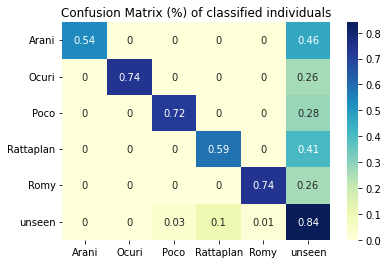

In [51]:
lbs, counts = np.unique(temp_y, return_counts=True)
temp = np.append(np.array(labels_seen)[lbs[:5].astype('int')], 'unseen')
matrix = np.round(confusion_matrix(pred, temp_y) / counts[:, None].T, 2).T
matrix = pd.DataFrame(matrix, index=temp, columns=temp)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classified individuals')
plt.show()

# 2. Triplet Loss

In [52]:
def evaluate_tl_open_set(lr = 0.001, k = 5, d_t =0.5):
    base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                      input_shape = (imsize, imsize, 3),
                                                      weights = 'imagenet')

    # freeze all the layers of VGG, so they won't be trained.
    for layer in base_model_16.layers:
        layer.trainable = False

    model_tl = tf.keras.models.Sequential([
        base_model_16,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024, activation='relu'),
        tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
    ])

    model_tl.compile(
        optimizer=tf.keras.optimizers.Adam(lr),
        loss=tfa.losses.TripletSemiHardLoss())

    model_tl.fit(x=x_train, y= y_train,
                 batch_size=batch_size,
                 epochs=EPOCHS,
                 verbose=1) 
        
    embedding_train_tl = []
    for i in range(len(y_train)):
        embedding_train_tl.append(model_tl.predict(x_train[i].reshape(1, imsize, imsize, 3))[0])
        
    embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

    knn_tl = KNeighborsClassifier(n_neighbors = k)
    knn_tl.fit(embedding_train_tl, y_train)
    
    #find the center point for each class in training set
    support_tl = []
    for i in np.unique(y_train):
        support_tl.append(np.mean(embedding_train_tl[y_train==i], axis=0))
        
    support_tl = np.array(support_tl, dtype=float)
    
    pred = []
    temp_x = np.append(x_val, X_unseen, axis=0)
    temp_y = np.append(y_val, Y_unseen, axis=0)
    
    arr = np.arange(temp_y.shape[0])
    np.random.shuffle(arr)
    
    temp_x = temp_x[arr]
    temp_y = temp_y[arr]
    
    for i in range(len(temp_y)):
        dists = []
        for j in range(len(np.unique(y_train))):
            embedding_test = model_tl.predict(temp_x[i].reshape(1, 150, 150, 3))
            embedding_anchor = support_tl[j]
            dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
            dists.append(dist)
        if min(dists) >= d_t:
            pred.append('unseen')
        else:
            pred.append(knn_tl.predict(embedding_test)[0])

    pred = np.array(pred)
    
    acc_open = round(np.mean(pred == temp_y), 2)
    print('The accuracy on the Open Dataset with triplet loss is {}'.format(acc_open))
    
    return acc_open

In [53]:
d_t = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

terms = {}
for i in d_t:
    terms['{}'.format(i)] = []

for train_index, test_index in skf.split(X_train, Y_train):
    x_train,x_val,y_train,y_val = X_train[train_index], X_train[test_index], Y_train[train_index], Y_train[test_index]
    
    for i in d_t:
        terms['{}'.format(i)].append(evaluate_tl_open_set(d_t = i))

Epoch 1/10
15/15 [==============================] - 2s 63ms/step - loss: 0.9711
Epoch 2/10
15/15 [==============================] - 1s 62ms/step - loss: 0.8805
Epoch 3/10
15/15 [==============================] - 1s 62ms/step - loss: 0.7728
Epoch 4/10
15/15 [==============================] - 1s 61ms/step - loss: 0.6247
Epoch 5/10
15/15 [==============================] - 1s 62ms/step - loss: 0.4841
Epoch 6/10
15/15 [==============================] - 1s 63ms/step - loss: 0.4657
Epoch 7/10
15/15 [==============================] - 1s 65ms/step - loss: 0.3927
Epoch 8/10
15/15 [==============================] - 1s 63ms/step - loss: 0.5321
Epoch 9/10
15/15 [==============================] - 1s 63ms/step - loss: 0.4273
Epoch 10/10
15/15 [==============================] - 1s 63ms/step - loss: 0.3310
The accuracy on the Open Dataset with triplet loss is 0.73
Epoch 1/10
15/15 [==============================] - 2s 62ms/step - loss: 0.9722
Epoch 2/10
15/15 [==============================] - 1s 62ms/

## Statisticl tests - Triplet Loss - Open Set

In [54]:
import pandas as pd
acc_tl_open_set = pd.DataFrame(terms)
table_tl_open_set = acc_tl_open_set.agg(['mean', 'std']).T
table_tl_open_set

,mean,std
0.2,0.714,0.018166
0.3,0.778,0.023875
0.4,0.718,0.047645
0.5,0.732,0.042071
0.6,0.636,0.055946
0.7,0.572,0.058907
0.8,0.446,0.032863


In [55]:
results = autorank(acc_tl_open_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
     meanrank   mean       std  ci_lower  ci_upper effect_size   magnitude
0.3       1.0  0.778  0.023875  0.735408  0.820592         0.0  negligible
0.5       2.6  0.732  0.042071  0.689408  0.774592    1.344822       large
0.4       3.2  0.718  0.047645  0.675408  0.760592    1.592235       large
0.2       3.4  0.714  0.018166  0.671408  0.756592    3.016989       large
0.6       4.8  0.636  0.055946  0.593408  0.678592    3.301433       large
0.7       6.0  0.572  0.058907  0.529408  0.614592     4.58344       large
0.8       7.0  0.446  0.032863  0.403408  0.488592   11.558756       large
pvalue=9.527279682232778e-12
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.25384601950645447, 0.29407089948654175, 0.8474657535552979, 0.08999375253915787, 0.08629408478736877, 0.17138025164604187, 0.1786789894104004]
homoscedastic=True
pval_homogeneity=0.31188507959755135
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.0071428571428571435
num_sa

/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


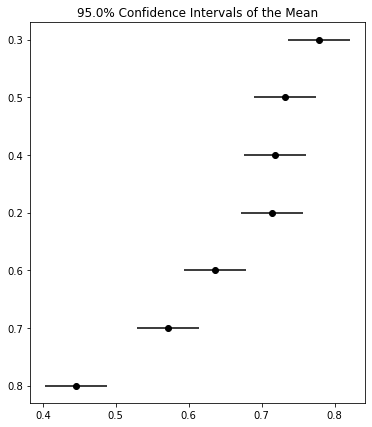

In [56]:
plot_stats(results)
plt.show()

In [57]:
create_report(results)

The statistical analysis was conducted for 7 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.086). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.312) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confide

In [58]:
acc_best_tl_open_set =  acc_tl_open_set['0.3']
acc_best_tl_open_set

0    0.80
1    0.74
2    0.79
3    0.79
4    0.77
Name: 0.3, dtype: float64

## Retrain Triplet Loss on open set

In [59]:
lr = 0.001
k = 5
d_t = 0.3


base_model_16 = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                  input_shape = (imsize, imsize, 3),
                                                  weights = 'imagenet')

# freeze all the layers of VGG, so they won't be trained.
for layer in base_model_16.layers:
    layer.trainable = False

model_tl = tf.keras.models.Sequential([
    base_model_16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(embeddingDim, activation=None), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(lr),
    loss=tfa.losses.TripletSemiHardLoss())

model_tl.fit(x = X_train, y = Y_train,
             batch_size=batch_size,
             epochs=EPOCHS,
             verbose=1) 
        
embedding_train_tl = []
for i in range(len(Y_train)):
    embedding_train_tl.append(model_tl.predict(X_train[i].reshape(1, imsize, imsize, 3))[0])
        
embedding_train_tl = np.array(embedding_train_tl, dtype=float) 

knn_tl = KNeighborsClassifier(n_neighbors = k)
knn_tl.fit(embedding_train_tl, Y_train)
    
#find the center point for each class in training set
support_tl = []
for i in np.unique(Y_train):
    support_tl.append(np.mean(embedding_train_tl[Y_train==i], axis=0))
        
support_tl = np.array(support_tl, dtype=float)
    
pred = []
temp_x = np.append(X_test, X_unseen, axis=0)
temp_y = np.append(Y_test, Y_unseen, axis=0)
    
arr = np.arange(temp_y.shape[0])
np.random.shuffle(arr)
    
temp_x = temp_x[arr]
temp_y = temp_y[arr]
    
for i in range(len(temp_y)):
    dists = []
    for j in range(len(np.unique(Y_train))):
        embedding_test = model_tl.predict(temp_x[i].reshape(1, 150, 150, 3))
        embedding_anchor = support_tl[j]
        dist = np.sum((embedding_test - embedding_anchor) ** 2) ** (1/2)
        dists.append(dist)
    if min(dists) >= d_t:
        pred.append('unseen')
    else:
        pred.append(knn_tl.predict(embedding_test)[0])

pred = np.array(pred)
    
acc_tl_test_open_set = round(np.mean(pred == temp_y), 2)
print('The accuracy on the test set with Open Dataset of Triplet Loss is {}'.format(acc_tl_test_open_set))

Epoch 1/10
18/18 [==============================] - 4s 195ms/step - loss: 0.9728
Epoch 2/10
18/18 [==============================] - 1s 65ms/step - loss: 0.8767
Epoch 3/10
18/18 [==============================] - 1s 64ms/step - loss: 0.7068
Epoch 4/10
18/18 [==============================] - 1s 67ms/step - loss: 0.7422
Epoch 5/10
18/18 [==============================] - 1s 69ms/step - loss: 0.4757
Epoch 6/10
18/18 [==============================] - 1s 64ms/step - loss: 0.4522
Epoch 7/10
18/18 [==============================] - 1s 65ms/step - loss: 0.4017
Epoch 8/10
18/18 [==============================] - 1s 65ms/step - loss: 0.3781
Epoch 9/10
18/18 [==============================] - 1s 65ms/step - loss: 0.2999
Epoch 10/10
18/18 [==============================] - 1s 64ms/step - loss: 0.2495
The accuracy on the test set with Open Dataset of Triplet Loss is 0.79


## Misclassified Monkeys - Open set (Triplet Loss)

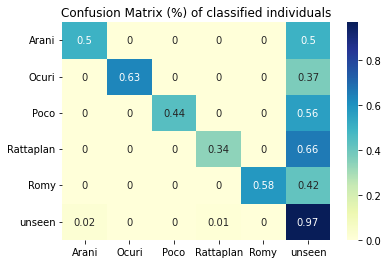

In [60]:
lbs, counts = np.unique(temp_y, return_counts=True)
temp = np.append(np.array(labels_seen)[lbs[:5].astype('int')], 'unseen')
matrix = np.round(confusion_matrix(pred, temp_y) / counts[:, None].T, 2).T
matrix = pd.DataFrame(matrix, index=temp, columns=temp)

sns.heatmap(matrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix (%) of classified individuals')
plt.show()

# Summary on Closed Set

In [61]:
# After tuning hps (lr and k), the best accuracy on val set.
best_vgg16 = table_vgg16.loc['0.001']
best_cl = table_cl_closed_set.loc['0.0001_1']
best_tl = table_tl_closed_set.loc['0.001_5']

pd.DataFrame({'VGG16_(LR = 0.001)': best_vgg16,
              'Contrastive_Loss(LR = 0.0001, k = 1)': best_cl, 
              'Triplet_Loss(LR = 0.001, k = 5)': best_tl
             })

,VGG16_(LR = 0.001),"Contrastive_Loss(LR = 0.0001, k = 1)","Triplet_Loss(LR = 0.001, k = 5)"
mean,0.897207,0.882000,0.902000
std,0.019164,0.026833,0.021679


In [62]:
# Accuracy on test set

pd.DataFrame([acc_test_vgg16, acc_cl_test_closed_set, acc_tl_test_closed_set], index = ['VGG16', 'Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,VGG16,Contrastive_Loss,Triplet_Loss
Accuracy,0.89,0.92,0.91


# Summary on Open Set

In [63]:
# After tuning hps (d_t), the best accuracy on val set.

best_cl = table_cl_open_set.loc['0.3']
best_tl = table_tl_open_set.loc['0.3']

pd.DataFrame({'Contrastive_Loss(d_t = 0.3)': best_cl, 
              'Triplet_Loss(d_t = 0.3)': best_tl
             })

,Contrastive_Loss(d_t = 0.3),Triplet_Loss(d_t = 0.3)
mean,0.736000,0.778000
std,0.008944,0.023875


In [64]:
# Accuracy on test set

pd.DataFrame([acc_cl_test_open_set, acc_tl_test_open_set], index = ['Contrastive_Loss', 'Triplet_Loss'], columns = ['Accuracy']).T

,Contrastive_Loss,Triplet_Loss
Accuracy,0.75,0.79


# Statistical tests - Overall

## Close Set

In [65]:
acc_closed_set = pd.DataFrame({'VGG16': acc_best_vgg16, 'Contrastive Loss': acc_best_cl_closed_set, 'Triplet Loss': acc_best_tl_closed_set})

In [66]:
results = autorank(acc_closed_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
                  meanrank      mean       std  ci_lower  ci_upper  \
Triplet Loss           1.5  0.902000  0.021679  0.882788  0.921212   
VGG16                  1.8  0.897207  0.019164  0.877995  0.916419   
Contrastive Loss       2.7  0.882000  0.026833  0.862788  0.901212   

                 effect_size   magnitude  
Triplet Loss             0.0  negligible  
VGG16                0.23426       small  
Contrastive Loss     0.81992       large  
pvalue=0.019501881473167625
cd=None
omnibus=anova
posthoc=tukeyhsd
all_normal=True
pvals_shapiro=[0.5345825552940369, 0.04595435410737991, 0.747101902961731]
homoscedastic=True
pval_homogeneity=0.8084107138358301
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


/opt/conda/lib/python3.7/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


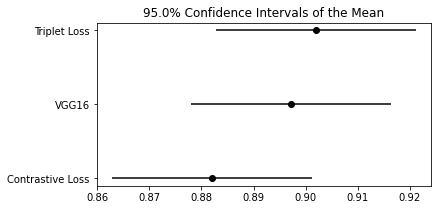

In [67]:
plot_stats(results)
plt.show()

In [68]:
create_report(results)

The statistical analysis was conducted for 3 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.046). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and failed to reject the null hypothesis (p=0.808) that the data is homoscedastic. Thus, we assume that our data is homoscedastic.
Because we have more than two populations and all populations are normal and homoscedastic, we use repeated measures ANOVA as omnibus test to determine if there are any significant differences between the mean values of the populations. If the results of the ANOVA test are significant, we use the post-hoc Tukey HSD test to infer which differences are significant. We report the mean value (M) and the standard deviation (SD) for each population. Populations are significantly different if their confide

## Open Set

In [69]:
acc_open_set = pd.DataFrame({'Contrastive Loss': acc_best_cl_open_set, 'Triplet Loss': acc_best_tl_open_set})

In [70]:
results = autorank(acc_open_set, alpha = 0.05, verbose=False)
print(results)

RankResult(rankdf=
                  meanrank   mean       std  ci_lower  ci_upper effect_size  \
Triplet Loss           1.1  0.778  0.023875  0.740679  0.815321         0.0   
Contrastive Loss       1.9  0.736  0.008944  0.722018  0.749982    2.329741   

                   magnitude  
Triplet Loss      negligible  
Contrastive Loss       large  
pvalue=0.02489616346022275
cd=None
omnibus=ttest
posthoc=None
all_normal=True
pvals_shapiro=[0.04595435410737991, 0.29407089948654175]
homoscedastic=True
pval_homogeneity=0.08395514700939309
homogeneity_test=bartlett
alpha=0.05
alpha_normality=0.025
num_samples=5
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=cohen_d)


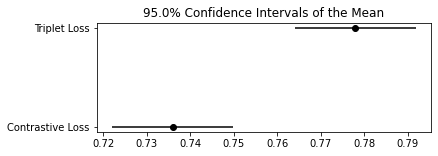

In [71]:
plot_stats(results)
plt.show()

In [72]:
create_report(results)

The statistical analysis was conducted for 2 populations with 5 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.046). Therefore, we assume that all populations are normal.
No check for homogeneity was required because we only have two populations.
Because we have only two populations and both populations are normal, we use the t-test to determine differences between the mean values of the populations and report the mean value (M)and the standard deviation (SD) for each population. 
We reject the null hypothesis (p=0.025) of the paired t-test that the mean values of the populations Triplet Loss (M=0.778+-0.037, SD=0.024) and Contrastive Loss (M=0.736+-0.014, SD=0.009) are equal. Therefore, we assume that the mean value of Triplet Loss is significantly larger than the mean value of Contrastive Loss with a large effect size (d=2.330).
